Removing the .DS_Store(hidden files) files in the training dataset

In [6]:
import os

dataset_dir = 'c:\\Users\\HADEEL GAMALELDIN\\Desktop\\Grad_proj\\Asl_Sign_Data\\asl_alphabet_train\\asl_alphabet_train'

# Traverse all subdirectories and remove .DS_Store files
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")

print("All .DS_Store files removed successfully!")


All .DS_Store files removed successfully!


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2


Data Visualisation

Classes: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


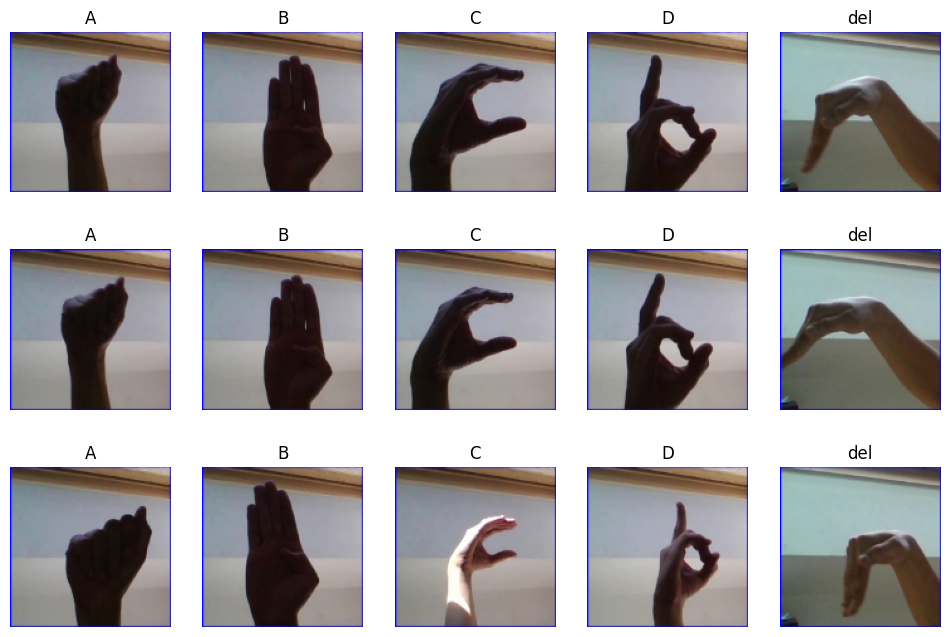

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_dir = 'c:\\Users\\HADEEL GAMALELDIN\\Desktop\\Grad_proj\\Asl_Sign_Data\\asl_alphabet_train\\asl_alphabet_train'

classes = os.listdir(dataset_dir)
print(f"Classes: {classes}")

# Visualize some images ,Creates a 3×5 grid of subplots where
#  sample images will be displayed.
fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, label in enumerate(classes[:5]):  # Show first 5 classes
    class_dir = os.path.join(dataset_dir, label)
    img_files = os.listdir(class_dir)[:3]  # Show 3 images per class

    for j, img_name in enumerate(img_files):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (128, 128))
        
        axes[j, i].imshow(img)
        axes[j, i].axis("off")
        axes[j, i].set_title(label)

plt.show()

Data Pre-processing

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be resized to 128×128×3.
#Training batches of 32 images at a time.

IMG_SIZE = 128 
BATCH_SIZE = 32

# You have ~87,000 images. Loading them all in RAM is expensive.
#ImageDataGenerator loads images batch-by-batch from disk, saving memory.

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting data into train (80%) and val (20%)
)

# Train & validation generators (load images directly from disk)
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print("Class labels:", train_generator.class_indices)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Class labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


Defining the MobileNet V2 Model

In [10]:
base_model = MobileNetV2(
    weights="imagenet", #Downloads pretrained MobileNetV2 weights from ImageNet.
    include_top=False, #removes the default classification layer.
    input_shape=(128, 128, 3) #This allows replacing it with custom layers for ASL data.
)

base_model.trainable = False  # Freezing all layers initially as this is an intial training

x = GlobalAveragePooling2D()(base_model.output) #Converts 4D feature maps into a single vector per channel.
#Reduces parameters significantly.

x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Initial training on the dataset

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5 
)

Epoch 1/5
  17/2175 [..............................] - ETA: 24:15 - loss: 3.4831 - accuracy: 0.1287

KeyboardInterrupt: 

Fine Tuning the model further

In [12]:
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile with a lower learning rate to avoid overfitting
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
  10/2175 [..............................] - ETA: 25:40 - loss: 3.0990 - accuracy: 0.1250

KeyboardInterrupt: 

In [8]:
model.save("sign_language_model_MobileNetV2.h5")
print("Model saved successfully!")

/Users/js/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


Model Testing

In [9]:
# Load the trained model
model = tf.keras.models.load_model("sign_language_model_MobileNetV2.h5")

print("Model loaded successfully!")

Model loaded successfully!


In [10]:
class_labels = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H",
    8: "I", 9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O",
    15: "P", 16: "Q", 17: "R", 18: "S", 19: "T", 20: "U", 21: "V",
    22: "W", 23: "X", 24: "Y", 25: "Z", 26: "del", 27: "nothing", 28: "space"
}


In [14]:
IMG_SIZE = 128 
test_folder = '/Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_test/asl_alphabet_test'
test_images = []
image_names = []

for img_name in os.listdir(test_folder):
    if img_name.endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(test_folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        test_images.append(img)
        image_names.append(img_name)

# Convert to NumPy array so it can be fed to the model.
test_images = np.array(test_images)

print(f"Loaded {len(test_images)} test images.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/js/Desktop/Sign Recognition Application/Sign_to_Sentence Project/Asl_Sign_Data/asl_alphabet_test/asl_alphabet_test'

In [12]:
# Get model predictions
predictions = model.predict(test_images)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

for i, img_name in enumerate(image_names):
    pred_label = class_labels[predicted_classes[i]]
    print(f"Image: {img_name} → Predicted as: {pred_label}")


2025-02-13 02:54:24.658219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 738ms/step
Image: F_test.jpg → Predicted as: F
Image: G_test.jpg → Predicted as: G
Image: L_test.jpg → Predicted as: L
Image: M_test.jpg → Predicted as: M
Image: R_test.jpg → Predicted as: R
Image: S_test.jpg → Predicted as: S
Image: X_test.jpg → Predicted as: X
Image: Y_test.jpg → Predicted as: Y
Image: U_test.jpg → Predicted as: U
Image: T_test.jpg → Predicted as: T
Image: A_test.jpg → Predicted as: A
Image: K_test.jpg → Predicted as: K
Image: J_test.jpg → Predicted as: J
Image: Z_test.jpg → Predicted as: Z
Image: nothing_test.jpg → Predicted as: nothing
Image: Q_test.jpg → Predicted as: Q
Image: P_test.jpg → Predicted as: P
Image: space_test.jpg → Predicted as: space
Image: O_test.jpg → Predicted as: O
Image: N_test.jpg → Predicted as: N
Image: E_test.jpg → Predicted as: E
Image: D_test.jpg → Predicted as: D
Image: H_test.jpg → Predicted as: H
Image: I_test.jpg → Predicted as: I
Image: B_test.jpg → Predicted as: B
Image: C_test.jpg → Predict

Test Accuracy

In [13]:
true_labels = [img_name.split("_")[0] for img_name in image_names]

correct = sum([1 if class_labels[predicted_classes[i]] == true_labels[i] else 0 for i in range(len(true_labels))])
accuracy = correct / len(true_labels) * 100

print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


Results Visualisation

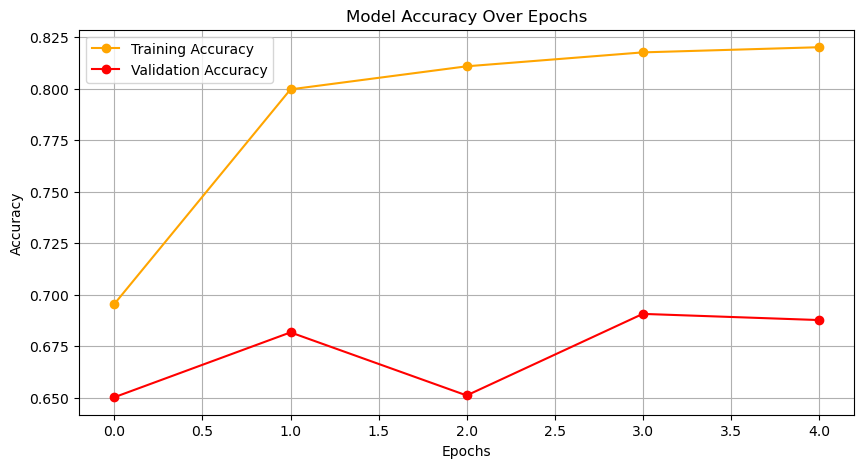

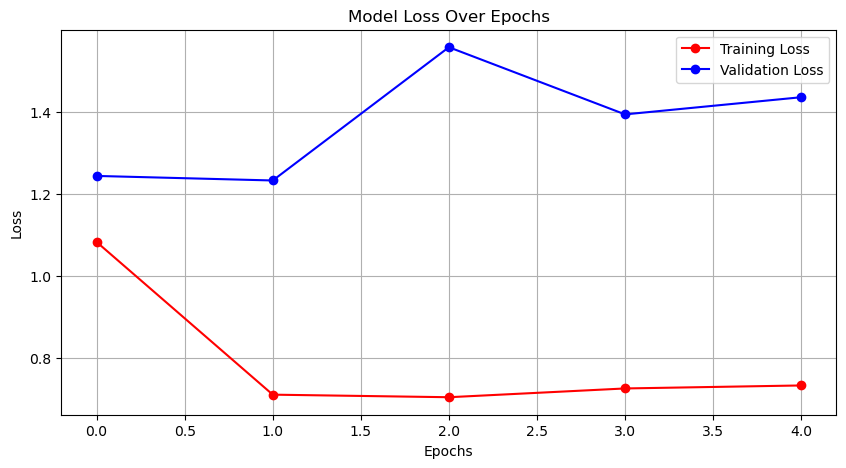

In [14]:
history_dict = history.history

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(history_dict["accuracy"], label="Training Accuracy", marker="o", color="orange")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy", marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(history_dict["loss"], label="Training Loss", marker="o", color="red")
plt.plot(history_dict["val_loss"], label="Validation Loss", marker="o", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


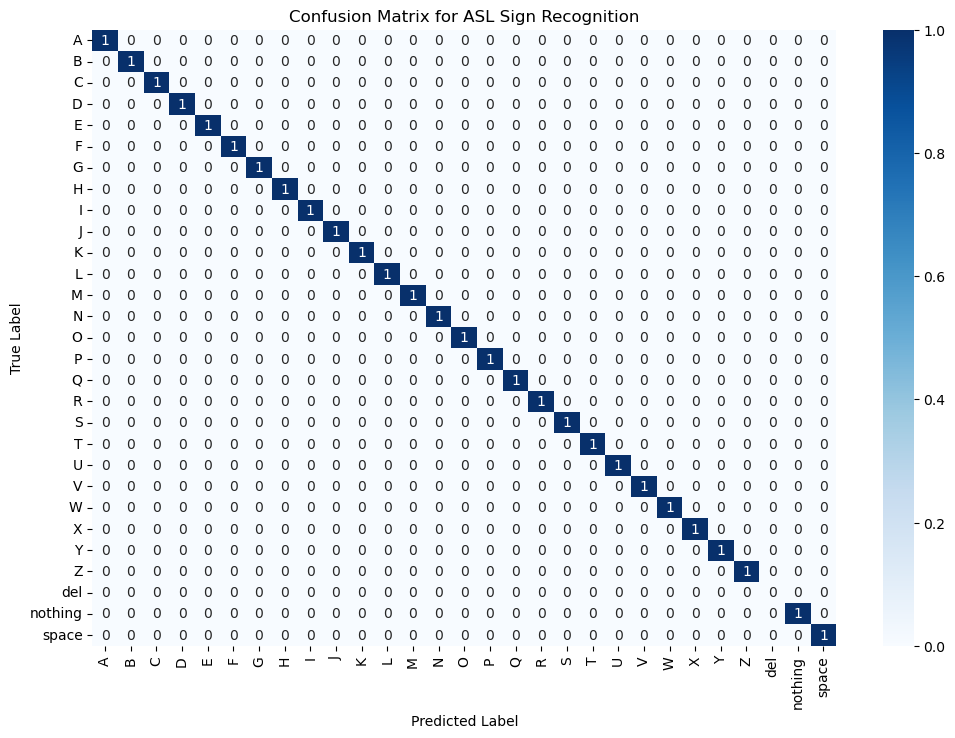

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Shows how often each letter was misclassified.
cm = confusion_matrix(true_labels, [class_labels[i] for i in predicted_classes], labels=list(class_labels.values()))

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ASL Sign Recognition")
plt.show()

Predicting the Signs from camera feed

- The approach is to use mediapipe to find the center of the hand, make a box/ frame around it, pass the image inside of frame to the trained model.

- Since MobileNet V2 is convolutional neural network, it would not give accurate results on real life data

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
import time

# Load trained MobileNetV2 model
mobilenet_model = tf.keras.models.load_model("sign_language_model_MobileNetV2.h5")

# Correct class labels
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

cap = cv2.VideoCapture(0)

# Bounding Box Adjustments
HEIGHT_EXPAND = 220
WIDTH_EXPAND = 150

# ------------------------------
# NEW: Stability + Cooldown Logic
# ------------------------------
buffer = []           # last 10 predictions
sentence = ""         # full typed output
last_time = time.time()
COOLDOWN = 1.0        # seconds

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rgb_frame = np.ascontiguousarray(rgb_frame, dtype=np.uint8)  # prevents mediapipe crash
    results = hands.process(rgb_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Get bounding box coordinates
            x_min = min([lm.x for lm in hand_landmarks.landmark]) * frame.shape[1]
            y_min = min([lm.y for lm in hand_landmarks.landmark]) * frame.shape[0]
            x_max = max([lm.x for lm in hand_landmarks.landmark]) * frame.shape[1]
            y_max = max([lm.y for lm in hand_landmarks.landmark]) * frame.shape[0]

            x_min = max(0, int(x_min - WIDTH_EXPAND))
            y_min = max(0, int(y_min - HEIGHT_EXPAND))
            x_max = min(frame.shape[1], int(x_max + WIDTH_EXPAND))
            y_max = min(frame.shape[0], int(y_max + HEIGHT_EXPAND))

            # Crop the hand region
            hand_crop = frame[y_min:y_max, x_min:x_max]

            if hand_crop.shape[0] > 0 and hand_crop.shape[1] > 0:
                # Resize to MobileNet size
                hand_resized = cv2.resize(hand_crop, (128, 128))
                hand_resized = np.expand_dims(hand_resized, axis=0) / 255.0

                # Predict
                prediction = mobilenet_model.predict(hand_resized, verbose=0)

                top_idx = np.argmax(prediction[0])
                predicted_label = class_labels[top_idx]

                # --------------------------
                # NEW: Stability Buffer
                # --------------------------
                buffer.append(predicted_label)
                if len(buffer) > 10:
                    buffer.pop(0)

                stable_letter = None
                # Check if buffer consistent (8/10 same)
                if buffer.count(buffer[0]) >= 8:
                    stable_letter = buffer[0]

                # --------------------------
                # NEW: Cooldown Logic
                # --------------------------
                if stable_letter is not None:
                    now = time.time()
                    
                    if now - last_time > COOLDOWN:
                        # Add letter to sentence
                        if stable_letter == "space":
                            sentence += " "
                        elif stable_letter == "del":
                            sentence = sentence[:-1]
                        elif stable_letter != "nothing":
                            sentence += stable_letter

                        last_time = now

                # Display predicted letter
                cv2.putText(frame, f"Prediction: {predicted_label}", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Display sentence
    cv2.putText(frame, f"Sentence: {sentence}", (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.imshow("MobileNetV2 Real-Time Prediction (Optimized)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


OSError: No file or directory found at sign_language_model_MobileNetV2.h5

After testing it is seen that this model is useful and clasifies the signs correctly which has distinct unique shapes like - letter A, L, etc but fails in complex signs like - letter K, X etc.